# Gluon RNN Classifier for Human activity recognition

Classify human activity based on smartphone accelerometer and gyroscope data with gluon. A handy extensible RNNClassifier Gluon is provided which makes it simple to use RNN for other problems. 

## Dataset

Human Activity Recognition Using Smartphones Data Set 

https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, we captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data. 

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

## Overview

Follow this link to see a video of how the data was collected:

<p align="center">
  <a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="Video of the experiment" width="400" height="300" border="10" /></a>
  <a href="https://youtu.be/XOEN9W05_4A"><center>[Watch video]</center></a>
</p>

In [46]:
# CODE

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
from sklearn import metrics

import os

INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

In [47]:
mx.__version__

'0.12.1'

## Data preparation

You can download the dataset and unzip it with its existing folder structure from https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones

** To make it easier, its been provided in the data/ folder **

In [48]:
### Load Data
train = ["data/har_data/train/%strain.txt" % signal for signal in INPUT_SIGNAL_TYPES]
test = ["data/har_data/test/%stest.txt" % signal for signal in INPUT_SIGNAL_TYPES]

def load_data(files):
    arr = []
    for fname in files:
        with open(fname, 'r') as f:
            rows = [row.replace('  ', ' ').strip().split(' ') for row in f]
            arr.append([np.array(ele, dtype=np.float32) for ele in rows])
    return np.transpose(np.array(arr), (1, 2, 0))

X_train = load_data(train)
X_test = load_data(test)

X_train.shape

(7352, 128, 9)

In [49]:
# Sample 0, time window 0
# 9 sensor data
X_train[0,0]

array([  1.81e-04,   1.08e-02,   5.56e-02,   3.02e-02,   6.60e-02,
         2.29e-02,   1.01e+00,  -1.23e-01,   1.03e-01], dtype=float32)

### Load training labels

In [50]:
import pandas as pd

y_train_path = "data/har_data/train/y_train.txt"

df = pd.read_csv(y_train_path, names=["labels"])
y_train = np.asarray(df.to_dict()['labels'].values()).astype('float32')

y_test_path = "data/har_data/test/y_test.txt"
df = pd.read_csv(y_test_path, names=["labels"])
y_test = np.asarray(df.to_dict()['labels'].values()).astype('float32')

y_train.shape, y_test.shape

((7352,), (2947,))

In [51]:
y_train = y_train - 1.0
y_test = y_test - 1.0

In [52]:
print(min(y_train), max(y_train))
print(min(y_test), max(y_test))

(0.0, 5.0)
(0.0, 5.0)


### A Gluon RNN Helper class has been provided here to help extend and reuse the same code for other problems

In [53]:
# RNN Helper class

import mxnet as mx
import numpy as np
import math
from mxnet import nd, autograd

def detach(hidden):
    if isinstance(hidden, (tuple, list)):
        hidden = [i.detach() for i in hidden]
    else:
        hidden = hidden.detach()
    return hidden

class BaseRNNClassifier(mx.gluon.Block):
    '''
    Exensible RNN class with LSTM that can operate with MXNet NDArray iter or DataLoader.
    Includes fit() function to mimic the symbolic fit() function
    '''
    
    @classmethod
    def get_data(cls, batch, iter_type, ctx):
        ''' get data and label from the iterator/dataloader '''
        if iter_type == 'mxiter':
            X = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
        elif iter_type in ["numpy", "dataloader"]:
            X = batch[0].as_in_context(ctx)
            y = batch[1].as_in_context(ctx)
        else:
            raise ValueError("iter_type must be mxiter or numpy")
        return X, y
    
    @classmethod
    def get_all_labels(cls, data_iterator, iter_type):
        if iter_type == 'mxiter':
            pass
        elif iter_type in ["numpy", "dataloader"]:
            return data_iterator._dataset._label
    
    def __init__(self, ctx):
        super(BaseRNNClassifier, self).__init__()
        self.ctx = ctx

    def build_model(self, n_out, rnn_size=128, n_layer=1):
        self.rnn_size = rnn_size
        self.n_layer = n_layer
        self.n_out = n_out
        
        self.lstm = mx.gluon.rnn.LSTM(self.rnn_size, self.n_layer, layout='NTC')
        #self.lstm = mx.gluon.rnn.GRU(self.rnn_size, self.n_layer)
        self.output = mx.gluon.nn.Dense(self.n_out)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        #x: batch_size, # of readings/windows, # of sensors e.g.(32L, 128L, 9L)
        out = out[:, out.shape[1]-1, :]
        out = self.output(out)
        return out, hidden

    def compile_model(self, loss=None, lr=3E-3):
        self.collect_params().initialize(mx.init.Xavier(), ctx=self.ctx)
        self.criterion = mx.gluon.loss.SoftmaxCrossEntropyLoss()
        self.loss = mx.gluon.loss.SoftmaxCrossEntropyLoss() if loss is None else loss
        self.lr = lr
        self.optimizer = mx.gluon.Trainer(self.collect_params(), 'adam', 
                                          {'learning_rate': self.lr})

    def top_k_acc(self, data_iterator, iter_type='mxiter', top_k=3, batch_size=128):
        batch_pred_list = []
        true_labels = []
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
            batch_pred = self.forward(data, hidden)
            #batch_pred = mx.nd.argmax(batch_pred, axis=1)
            batch_pred_list.append(batch_pred.asnumpy())
            true_labels.append(label)
        y = np.vstack(batch_pred_list)
        true_labels = np.vstack(true_labels)
        argsorted_y = np.argsort(y)[:,-top_k:]
        return np.asarray(np.any(argsorted_y.T == true_labels, axis=0).mean(dtype='f'))
    
    def evaluate_accuracy(self, data_iterator, metric='acc', iter_type='mxiter', batch_size=128):
        met = mx.metric.Accuracy()
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
            # Lets do a forward pass only!
            output, hidden = self.forward(data, hidden)
            preds = mx.nd.argmax(output, axis=1)
            met.update(labels=label, preds=preds)
                
        #if self.all_labels is None:
        #    self.all_labels = BaseRNNClassifier.get_all_labels(data_iterator, iter_type)
        #preds = self.predict(data_iterator, iter_type=iter_type, batch_size=batch_size)
        #met.update(labels=mx.nd.array(self.all_labels[:len(preds)]), preds=preds)
        
        return met.get()                   
                    
    def predict(self, data_iterator, iter_type='mxiter', batch_size=128):
        batch_pred_list = []
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
            output, hidden = self.forward(data, hidden)
            batch_pred_list.append(output.asnumpy())
        #return np.vstack(batch_pred_list)
        return np.argmax(np.vstack(batch_pred_list), 1)
    
    def fit(self, train_data, test_data, epochs, batch_size, verbose=True):
        '''
        @train_data:  can be of type list of Numpy array, DataLoader, MXNet NDArray Iter
        '''
        
        moving_loss = 0.
        total_batches = 0

        train_loss = []
        train_acc = []
        test_acc = []

        iter_type = 'numpy'
        train_iter = None
        test_iter = None
        print "Data type:", type(train_data), type(test_data), iter_type, type(train_data[0])
        
        # Can take MX NDArrayIter, or DataLoader
        if isinstance(train_data, mx.io.NDArrayIter):
            train_iter = train_data
            test_iter = test_data
            iter_type = 'mxiter'
            #total_batches = train_iter.num_data // train_iter.batch_size

        elif isinstance(train_data, list):
            if isinstance(train_data[0], np.ndarray) and isinstance(train_data[1], np.ndarray):
                X, y = np.asarray(train_data[0]).astype('float32'), np.asarray(train_data[1]).astype('float32')
                tX, ty = np.asarray(test_data[0]).astype('float32'), np.asarray(test_data[1]).astype('float32')
                
                total_batches = X.shape[0] // batch_size
                train_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(X, y), 
                                    batch_size=batch_size, shuffle=True, last_batch='discard')
                test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(tX, ty), 
                                    batch_size=batch_size, shuffle=False, last_batch='discard')
                
        elif isinstance(train_data, mx.gluon.data.dataloader.DataLoader) and isinstance(test_data, mx.gluon.data.dataloader.DataLoader):
            train_iter = train_data
            test_iter = test_data
            total_batches = len(train_iter)
        else:
            raise ValueError("pass mxnet ndarray or numpy array as [data, label]")

        print "Data type:", type(train_data), type(test_data), iter_type
        print "Sizes", self.n_layer, batch_size, self.rnn_size, self.ctx
        
        for e in range(epochs):
            #print self.lstm.collect_params()

            # reset iterators if of MXNet Itertype
            if iter_type == "mxiter":
                train_iter.reset()
                test_iter.reset()
        
            init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
            hidden = [init_state] * 2                
            #hidden = self.begin_state(func=mx.nd.zeros, batch_size=batch_size, ctx=self.ctx)
            yhat = []

            for i, batch in enumerate(train_iter):
                data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
                #print "Data Shapes:", data.shape, label.shape
                hidden = detach(hidden)
                #with mx.gluon.autograd.record(train_mode=True):
                with autograd.record():
                    preds, hidden = self.forward(data, hidden)
                    #print preds[0].shape, hidden[0].shape, label.shape
                    loss = self.loss(preds, label) 
                    yhat.extend(preds)
                loss.backward()                                        
                self.optimizer.step(batch_size)
                preds = mx.nd.argmax(preds, axis=1)
                
                batch_acc = mx.nd.mean(preds == label).asscalar()

                if i == 0:
                    moving_loss = nd.mean(loss).asscalar()
                else:
                    moving_loss = .99 * moving_loss + .01 * mx.nd.mean(loss).asscalar()
                    
                if verbose and i%100 == 0:
                    print('[Epoch {}] [Batch {}/{}] Loss: {:.5f}, Batch acc: {:.5f}'.format(
                          e, i, total_batches, moving_loss, batch_acc))                    
                    
            train_loss.append(moving_loss)
            
            t_acc = self.evaluate_accuracy(train_iter, iter_type=iter_type, batch_size=batch_size)
            train_acc.append(t_acc[1])
            
            tst_acc = self.evaluate_accuracy(test_iter, iter_type=iter_type, batch_size=batch_size)
            test_acc.append(tst_acc[1])

            print("Epoch %s. Loss: %.5f Train Acc: %s Test Acc: %s" % (e, moving_loss, t_acc, tst_acc))
        return train_loss, train_acc, test_acc
                    
    def predict(self, data_iterator, iter_type='mxiter', batch_size=128):
        batch_pred_list = []
        init_state = mx.nd.zeros((self.n_layer, batch_size, self.rnn_size), self.ctx)
        hidden = [init_state] * 2
        for i, batch in enumerate(data_iterator):
            data, label = BaseRNNClassifier.get_data(batch, iter_type, self.ctx)
            output, hidden = self.forward(data, hidden)
            batch_pred_list.append(output.asnumpy())
        return np.argmax(np.vstack(batch_pred_list), 1)

### Network definition and training

In [54]:
ctx = mx.gpu(0) #change context to execute on CPU
model = BaseRNNClassifier(ctx)
model.build_model(n_out=len(LABELS), rnn_size=64, n_layer=1)
model.compile_model()
train_loss, train_acc, test_acc = model.fit([X_train, y_train], [X_test, y_test], batch_size=32, epochs=5)

Data type: <type 'list'> <type 'list'> numpy <type 'numpy.ndarray'>
Data type: <type 'list'> <type 'list'> numpy
Sizes 1 32 64 gpu(0)
[Epoch 0] [Batch 0/229] Loss: 1.81909, Batch acc: 0.03125
[Epoch 0] [Batch 100/229] Loss: 1.55844, Batch acc: 0.34375
[Epoch 0] [Batch 200/229] Loss: 1.23502, Batch acc: 0.62500
Epoch 0. Loss: 1.13347 Train Acc: ('accuracy', 0.6683951965065502) Test Acc: ('accuracy', 0.6328125)
[Epoch 1] [Batch 0/229] Loss: 0.79911, Batch acc: 0.65625
[Epoch 1] [Batch 100/229] Loss: 0.74719, Batch acc: 0.68750
[Epoch 1] [Batch 200/229] Loss: 0.67408, Batch acc: 0.75000
Epoch 1. Loss: 0.66980 Train Acc: ('accuracy', 0.7434497816593887) Test Acc: ('accuracy', 0.6963315217391305)
[Epoch 2] [Batch 0/229] Loss: 0.60161, Batch acc: 0.65625
[Epoch 2] [Batch 100/229] Loss: 0.54828, Batch acc: 0.71875
[Epoch 2] [Batch 200/229] Loss: 0.50986, Batch acc: 0.78125
Epoch 2. Loss: 0.47863 Train Acc: ('accuracy', 0.8767740174672489) Test Acc: ('accuracy', 0.8148777173913043)
[Epoch 3] [

#### Lets plot accuracy and loss over each epoch

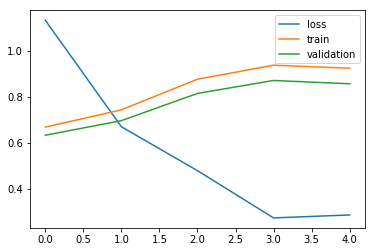

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(train_loss, label="loss")
plt.plot(train_acc, label="train")
plt.plot(test_acc, label="validation")
plt.legend()
plt.show()

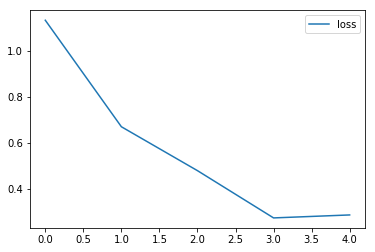

In [56]:
# Loss plot

plt.plot(train_loss, label="loss")
plt.legend()
plt.show()

In [57]:
tX, ty = np.asarray(X_test).astype('float32'), np.asarray(y_test).astype('float32')
test_iter = mx.gluon.data.DataLoader(mx.gluon.data.ArrayDataset(tX, ty), 
                                    batch_size=128, shuffle=False, last_batch='discard')

In [58]:
evl = model.evaluate_accuracy(test_iter, iter_type='numpy')
print(evl)

('accuracy', 0.8586956521739131)


In [59]:
preds = model.predict(test_iter, iter_type='numpy')

In [60]:
from sklearn.metrics import confusion_matrix
cm_grid = confusion_matrix(y_true=y_test[:len(preds)],  # True class for test-set.
                      y_pred=preds)  # Predicted class.

print(cm_grid)

[[405   8  47   6  30   0]
 [ 49 387  31   0   1   0]
 [  4   4 410   1   1   0]
 [  2   1   0 380 108   0]
 [  5   0   0  98 429   0]
 [  0  20   0   0   0 517]]


In [61]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[405   8  47   6  30   0]
 [ 49 387  31   0   1   0]
 [  4   4 410   1   1   0]
 [  2   1   0 380 108   0]
 [  5   0   0  98 429   0]
 [  0  20   0   0   0 517]]


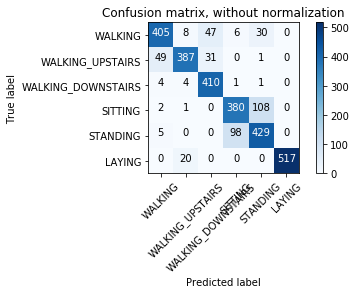

In [62]:
# Compute confusion matrix Head Pose 
cnf_matrix = cm_grid
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS,
                      title='Confusion matrix, without normalization')

plt.rc('figure', figsize=(10.0, 10.0))

Normalized confusion matrix
[[ 0.82  0.02  0.09  0.01  0.06  0.  ]
 [ 0.1   0.83  0.07  0.    0.    0.  ]
 [ 0.01  0.01  0.98  0.    0.    0.  ]
 [ 0.    0.    0.    0.77  0.22  0.  ]
 [ 0.01  0.    0.    0.18  0.81  0.  ]
 [ 0.    0.04  0.    0.    0.    0.96]]


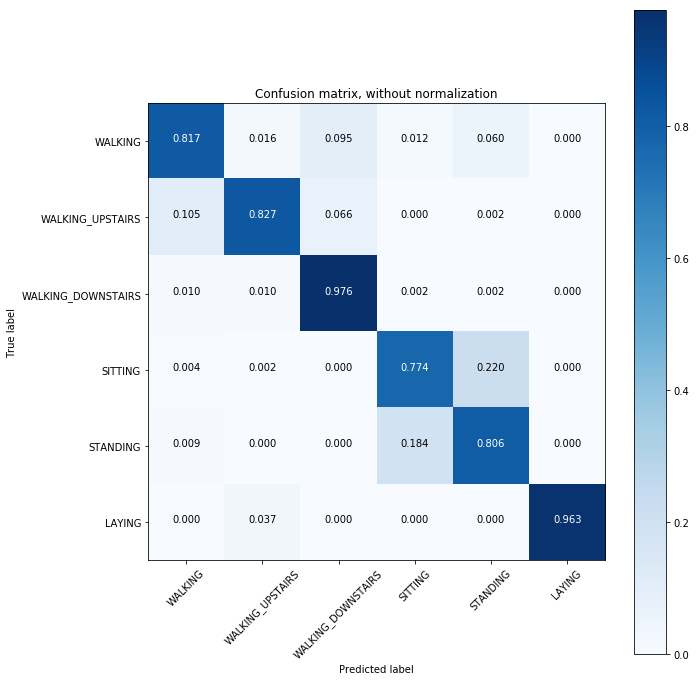

In [63]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=LABELS, normalize=True,
                      title='Confusion matrix, without normalization')

plt.rc('figure', figsize=(10.0, 10.0))

## Excercise 

1. Build the confusion matrix 
2. Try plotting the misclassified samples
3. Can we use a CNN to solve this problem? 